##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\3.08"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
                                           #6/1/2021 1:00:04 AM\n
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%m/%d/%Y %H:%M:%S AM\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

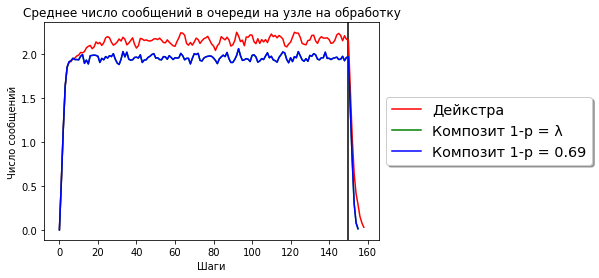

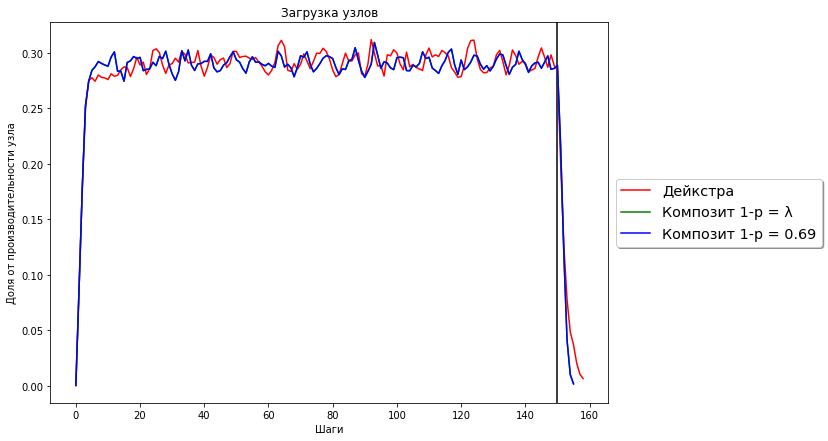

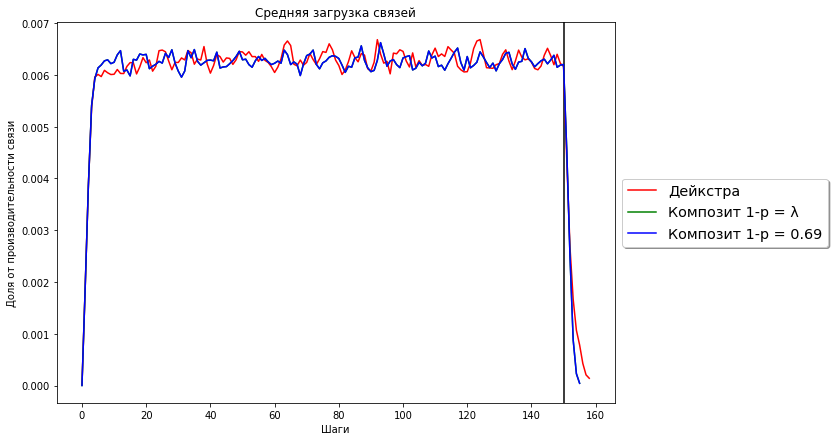

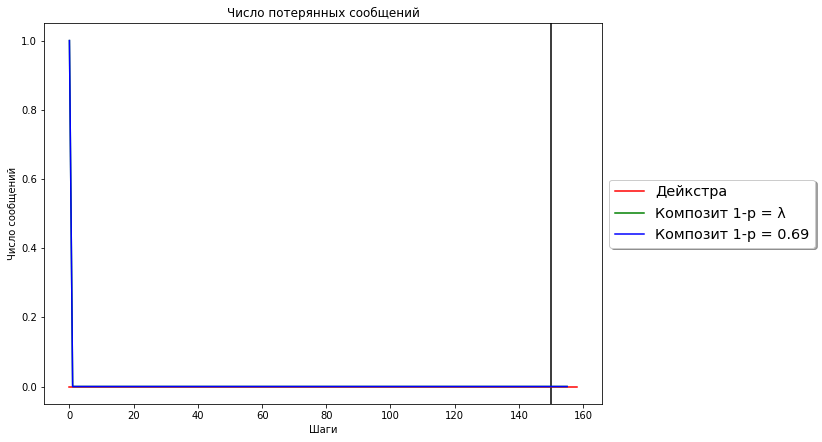

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.69


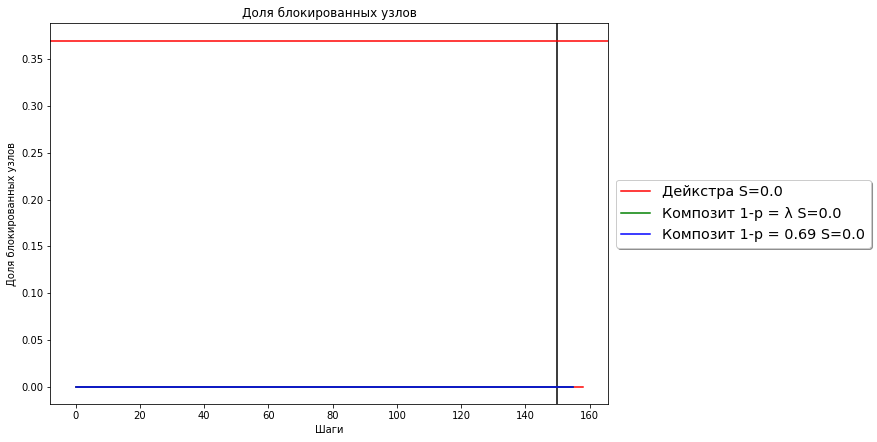

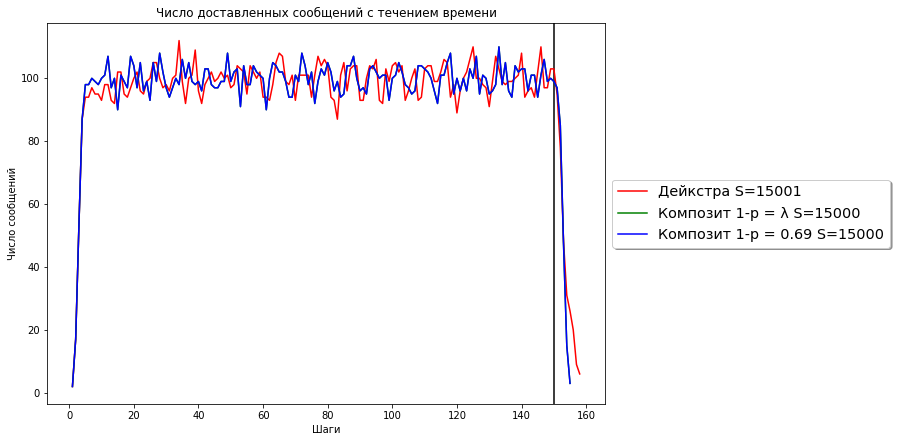

In [3]:
log_tags = [
 {"tag":  "ed1c7e50-d4cd-48c6-8a74-f6ba10782a31", "label": "Дейкстра", "color": "red"},
 #{"tag":  "41102665-f5b4-4dc5-b759-c5ab083ee254", "label": "Композит 1-p = 0.95", "color": "magenta"},
 {"tag":  "1a99401c-6347-42df-8027-afac317443fd", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "92adecdd-7bac-4fa5-a5c1-bd0f2315f72c", "label": "Композит 1-p = 0.69", "color": "blue"},
    #  magenta red green black
 
]     
quantity = 100;

showStat()
showStatBlocked();  
showStatMessage(); 


<strong>Quantity 500 </strong>

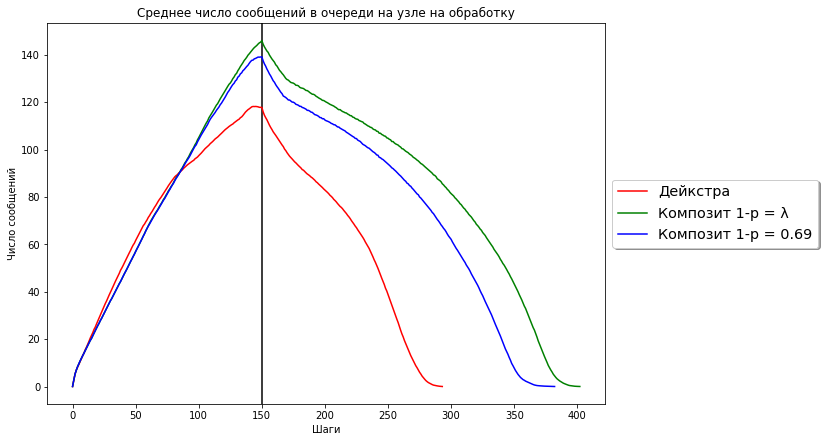

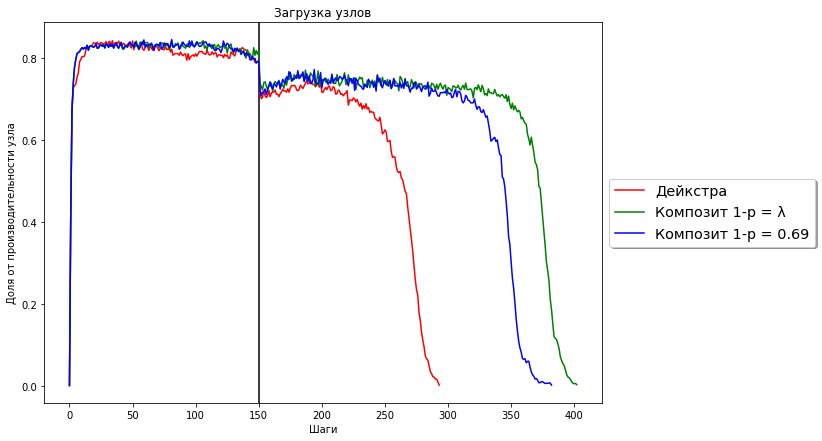

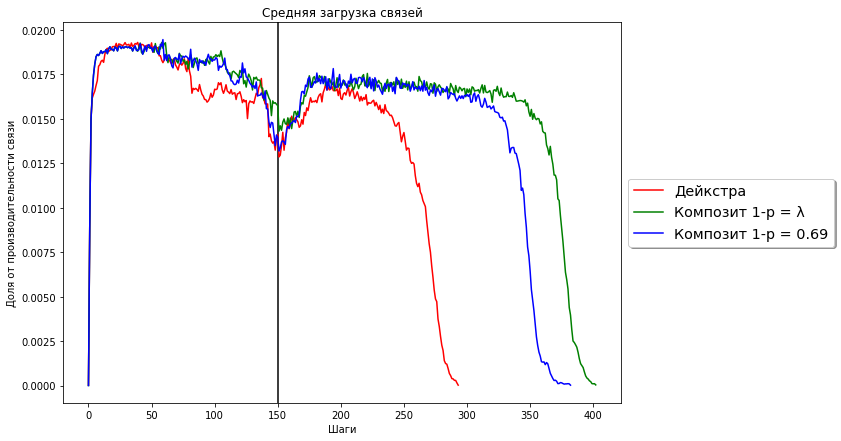

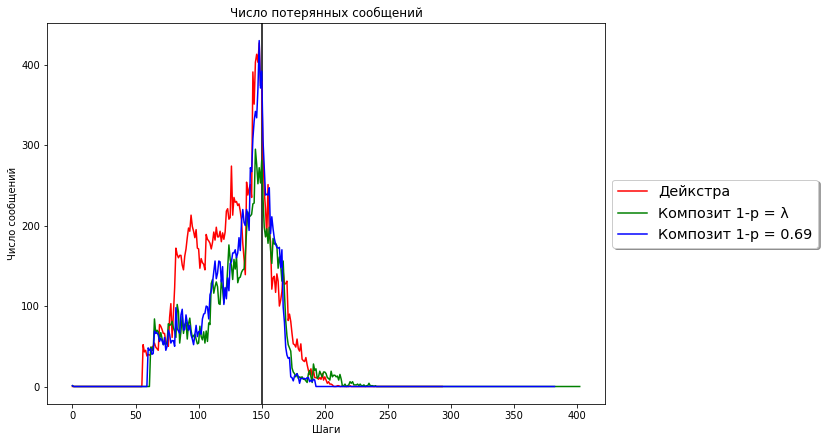

Доставлено 54350 Потеряно 27.5343% -Дейкстра
Доставлено 60890 Потеряно 18.8144% -Композит 1-p = λ
Доставлено 59362 Потеряно 20.8517% -Композит 1-p = 0.69


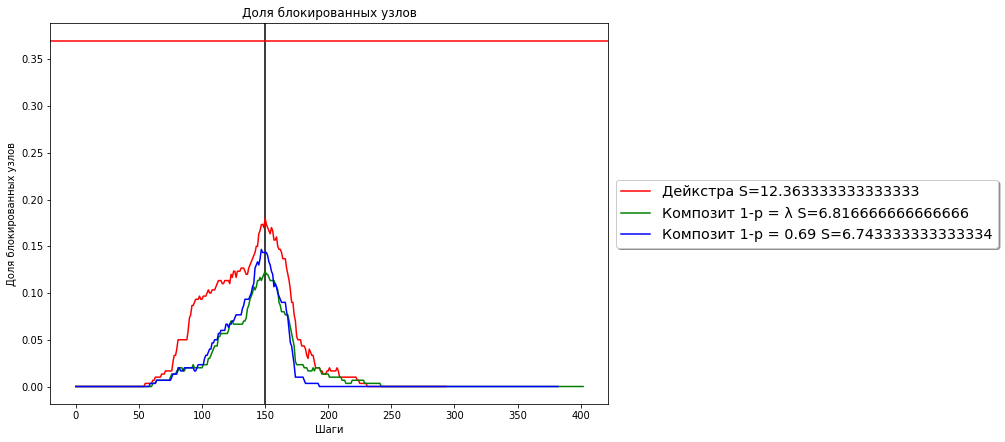

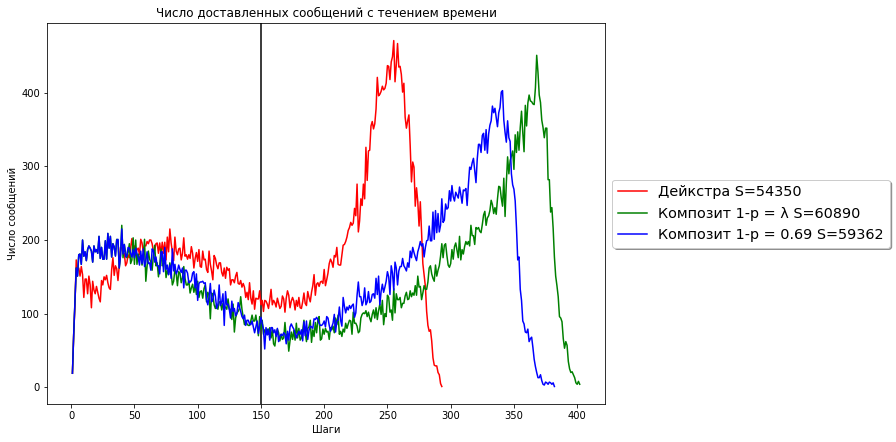

In [4]:
log_tags = [
 {"tag":  "f03085de-1ce1-4f8b-9440-f7e919994c03", "label": "Дейкстра", "color": "red"},
 #{"tag":  "fbd38502-b94e-4317-b534-3d205f59142c", "label": "Композит 1-p = 0.95", "color": "m"},
 {"tag":  "e7b8b03e-e0ae-44be-8cd2-6908fb71c32b", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "425ca404-e52d-4a82-a5c0-ff3d4bd822dc", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 500;  
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

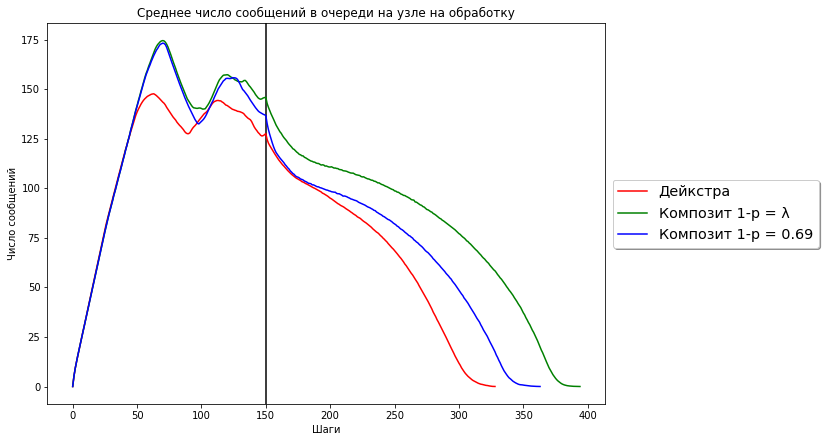

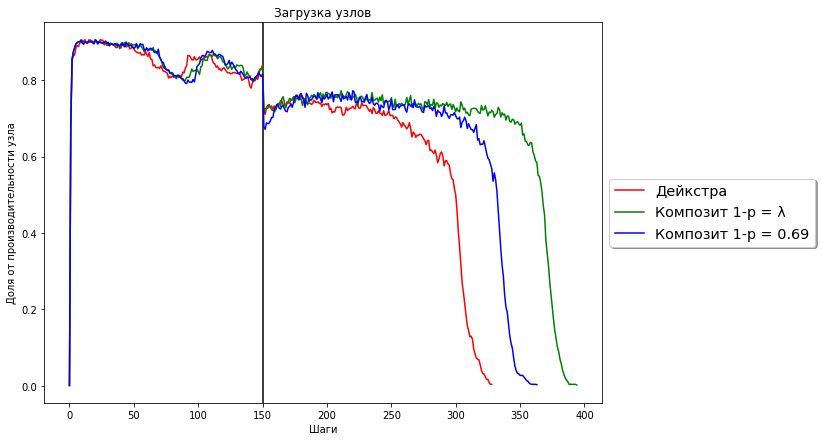

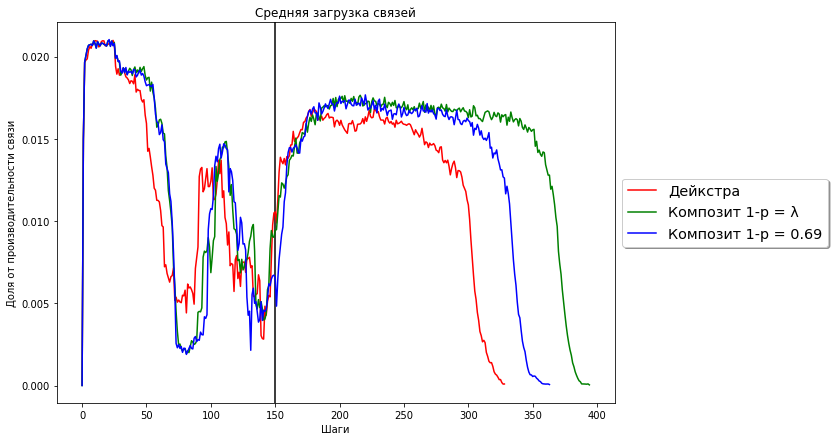

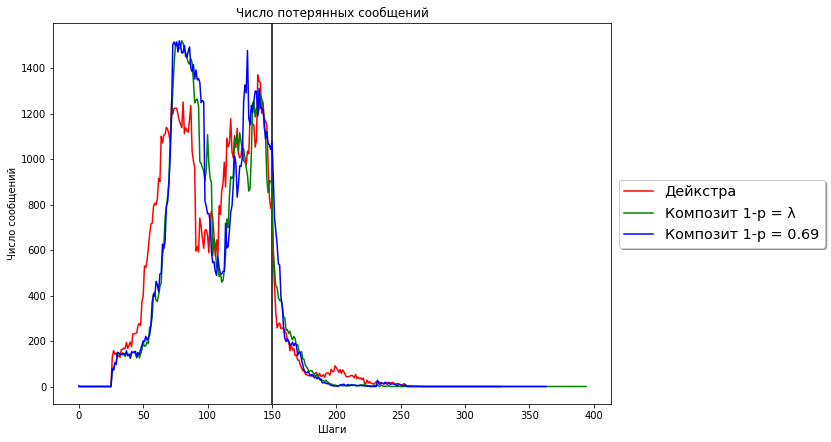

Доставлено 40476 Потеряно 73.0162% -Дейкстра
Доставлено 44959 Потеряно 70.0275% -Композит 1-p = λ
Доставлено 41521 Потеряно 72.3195% -Композит 1-p = 0.69


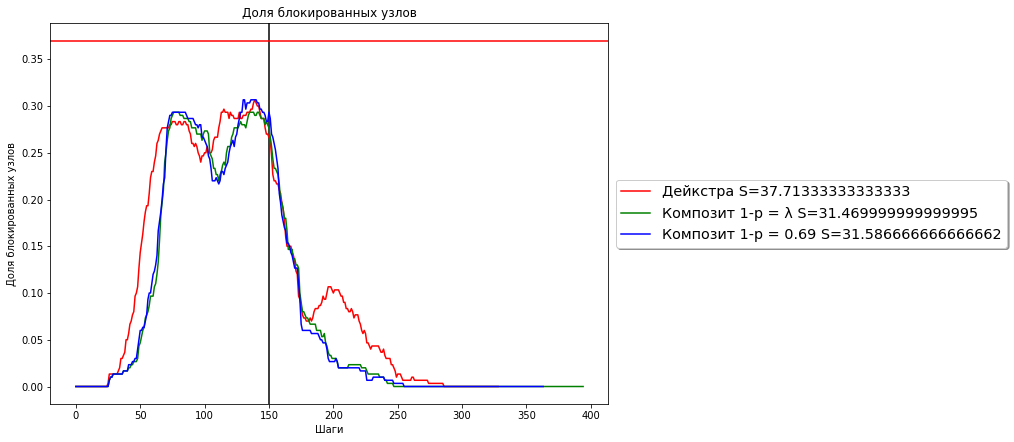

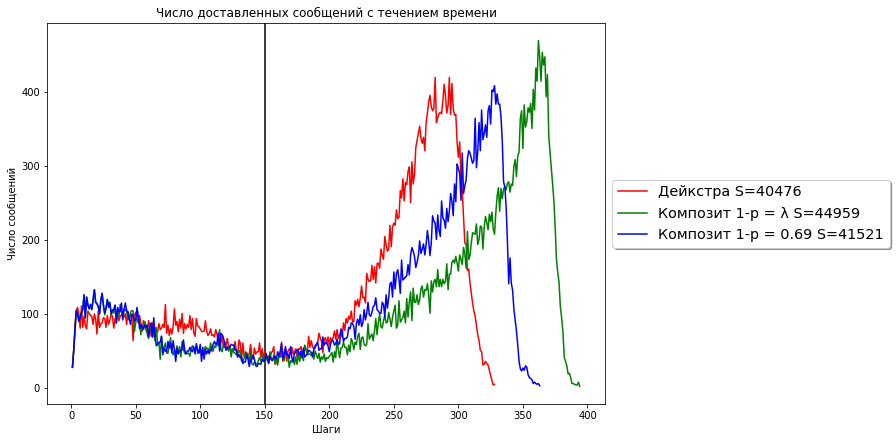

In [5]:
log_tags = [
 {"tag":  "96a3b673-958d-4e1a-bb40-7b9006e703ae", "label": "Дейкстра", "color": "red"},
 #{"tag":  "5fd9539d-b6a4-4ea9-bf26-6475713040ac", "label": "Композит 1-p = 0.95", "color": "m"},
 {"tag":  "d496ac5f-17c4-4521-8fc0-7aafc49bbf44", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "ad984086-3899-4c2e-b63a-027f51c9ba4a", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1000;  
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

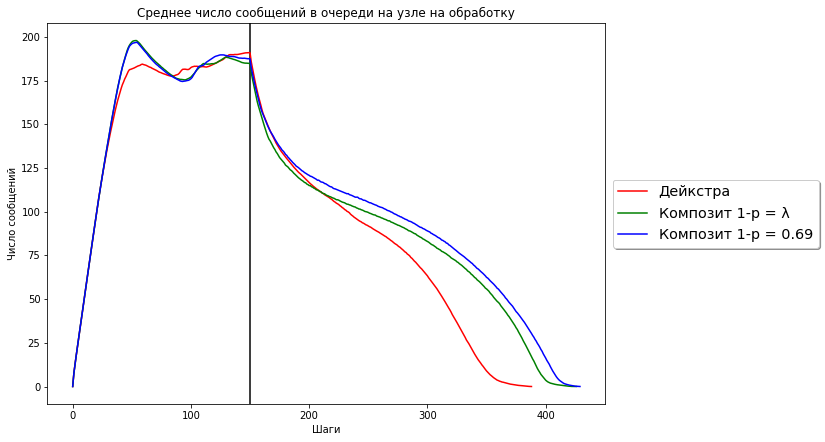

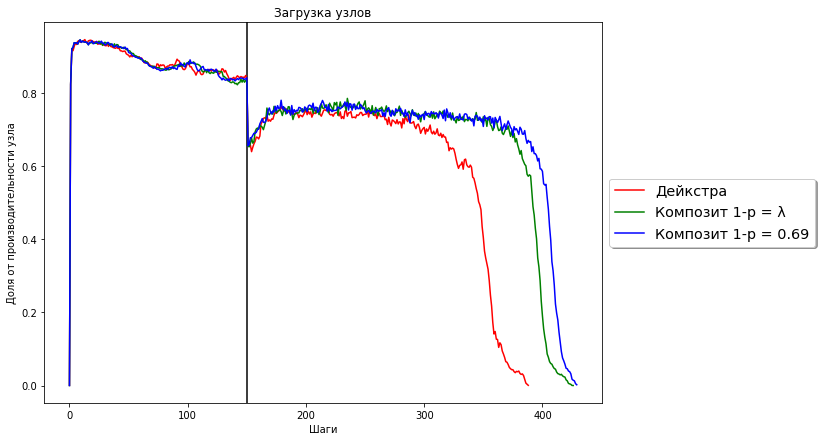

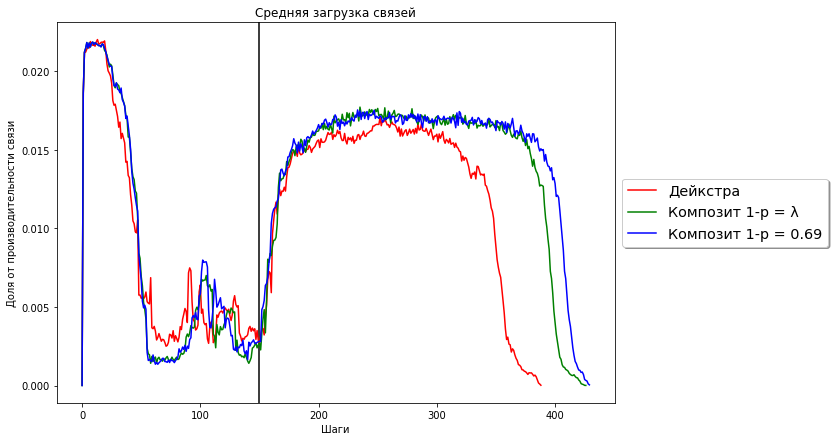

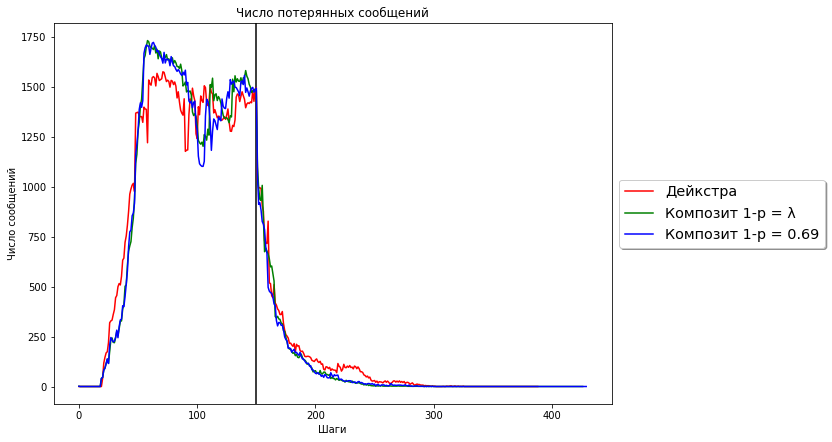

Доставлено 39463 Потеряно 82.4610% -Дейкстра
Доставлено 41207 Потеряно 81.6859% -Композит 1-p = λ
Доставлено 43165 Потеряно 80.8156% -Композит 1-p = 0.69


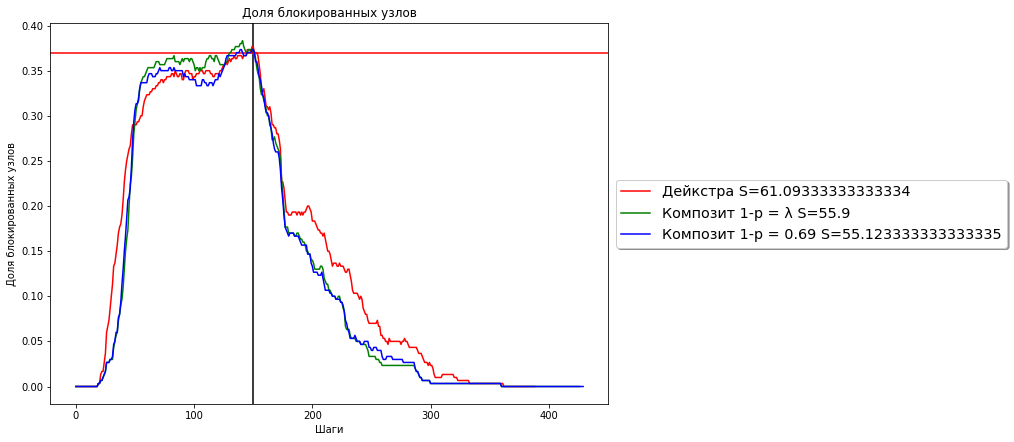

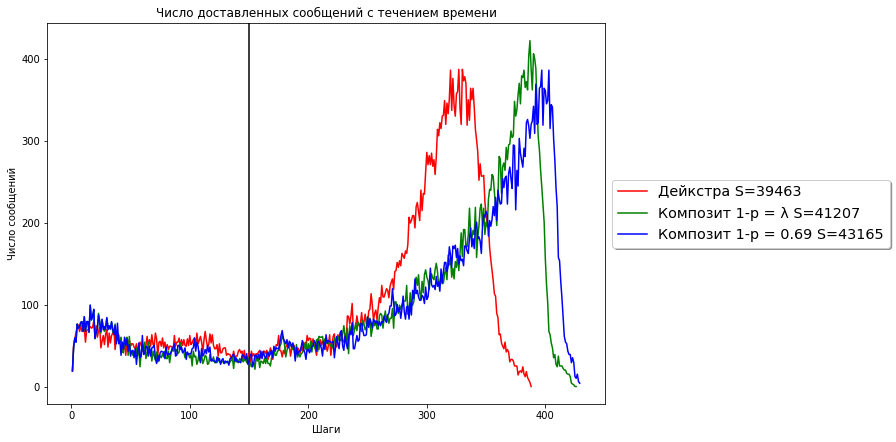

In [6]:
log_tags = [
 {"tag":  "3e5c8d59-e21d-485c-897e-3311df5ef3d0", "label": "Дейкстра", "color": "red"},
 #{"tag":  "ec3d1521-bf86-4069-95ac-7b168d05a92c", "label": "Композит 1-p = 0.95", "color": "m"},
 {"tag":  "eef72215-33e3-4671-add3-023ef558705d", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "323c9bbc-a464-462c-aa91-f10ae61841b6", "label": "Композит 1-p = 0.69", "color": "blue"},
]
quantity = 1500;  
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 44000 Потеряно 2.2244% -Дейкстра
Доставлено 44058 Потеряно 2.0955% -Композит 1-p = λ
Доставлено 44058 Потеряно 2.0955% -Композит 1-p = 0.69


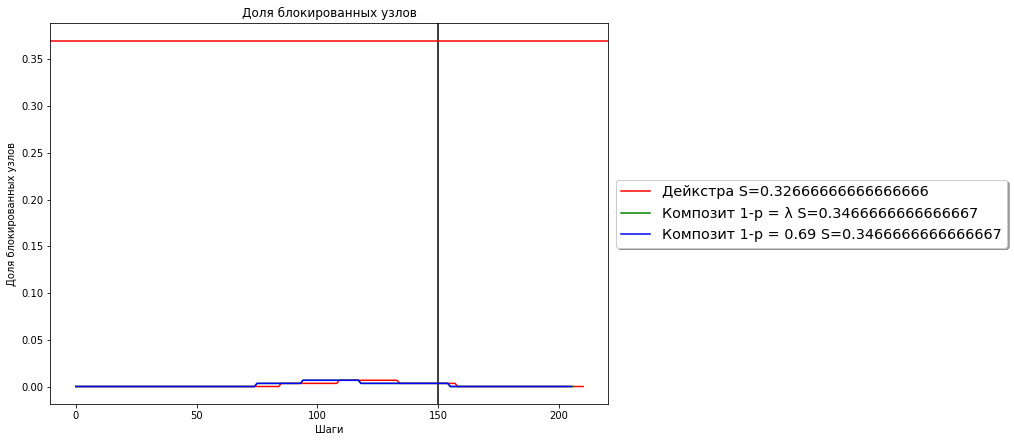

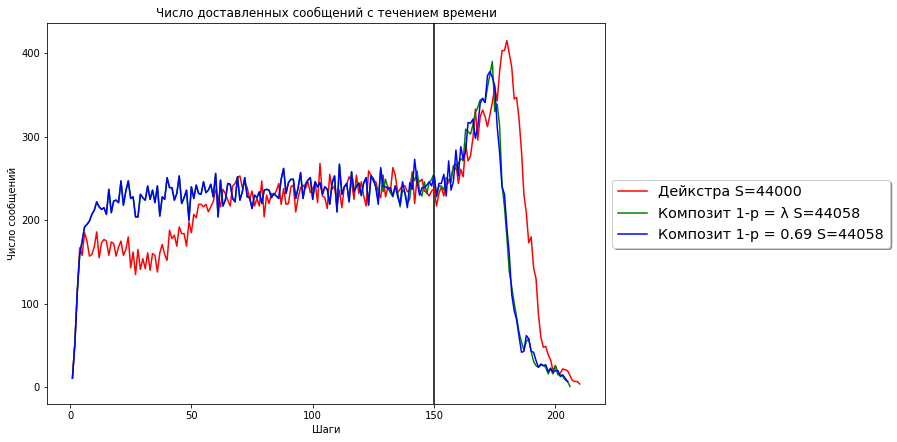

Доставлено 45851 Потеряно 56.3328% -Дейкстра
Доставлено 49111 Потеряно 53.2281% -Композит 1-p = λ
Доставлено 47253 Потеряно 54.9976% -Композит 1-p = 0.69


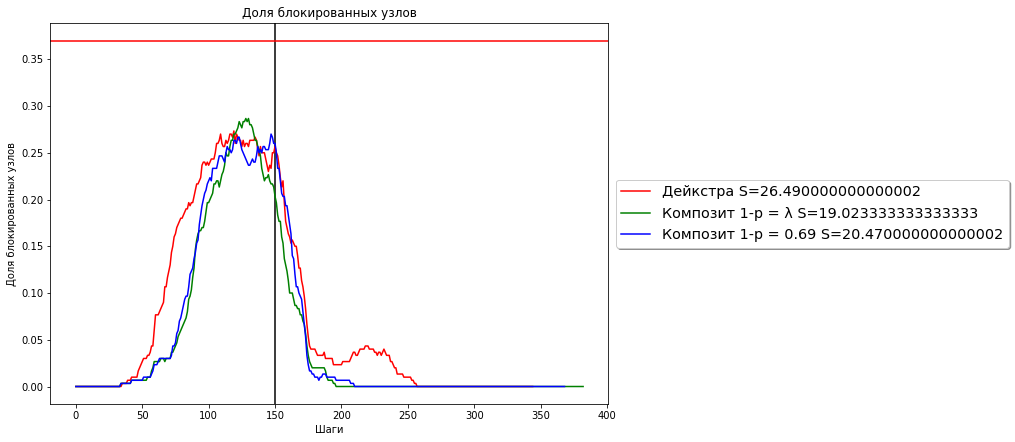

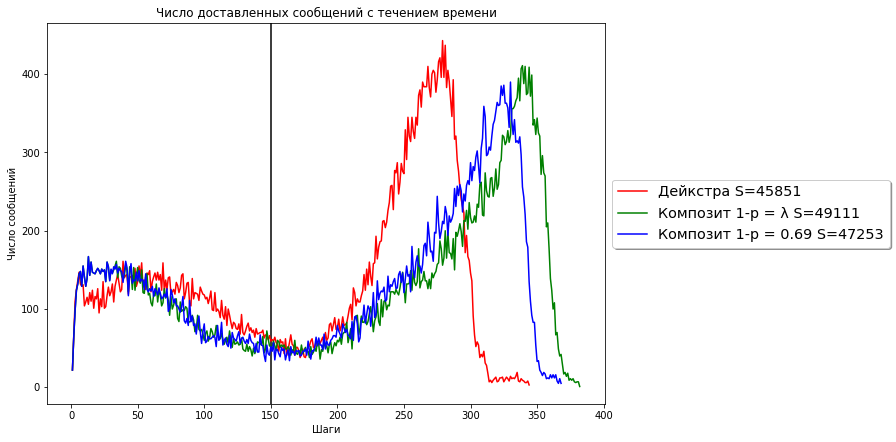

Доставлено 42302 Потеряно 68.6654% -Дейкстра
Доставлено 43341 Потеряно 67.8958% -Композит 1-p = λ
Доставлено 45363 Потеряно 66.3980% -Композит 1-p = 0.69


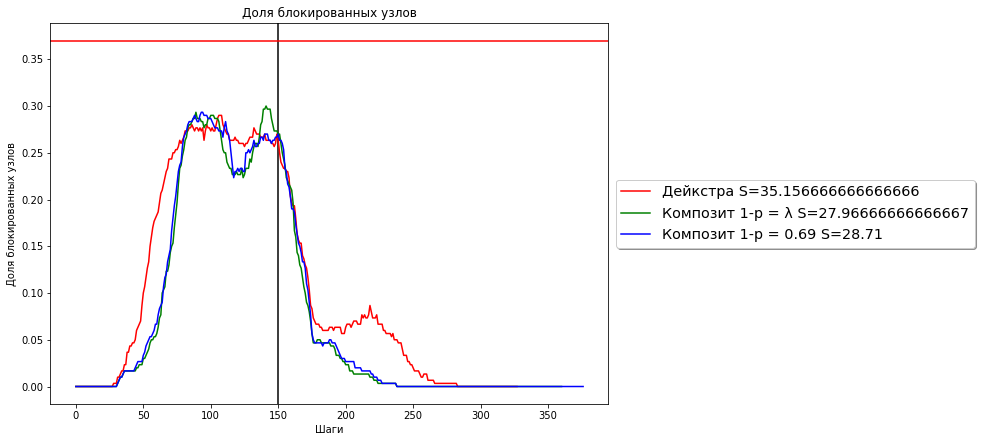

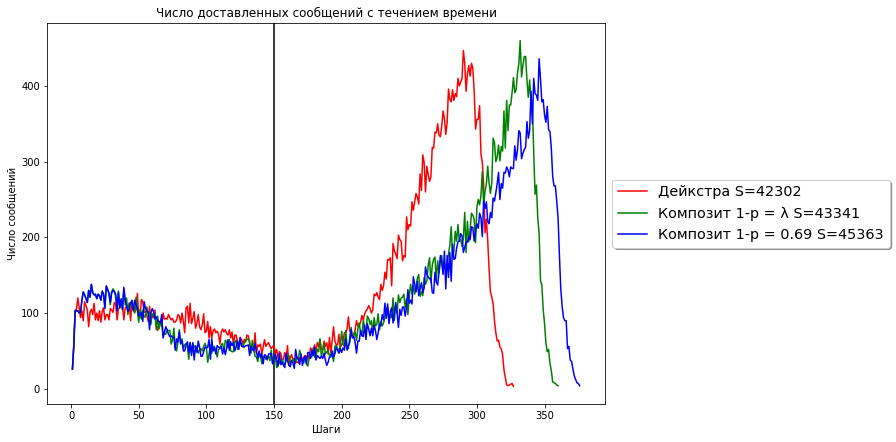

Доставлено 40463 Потеряно 79.2499% -Дейкстра
Доставлено 43324 Потеряно 77.7827% -Композит 1-p = λ
Доставлено 44140 Потеряно 77.3642% -Композит 1-p = 0.69


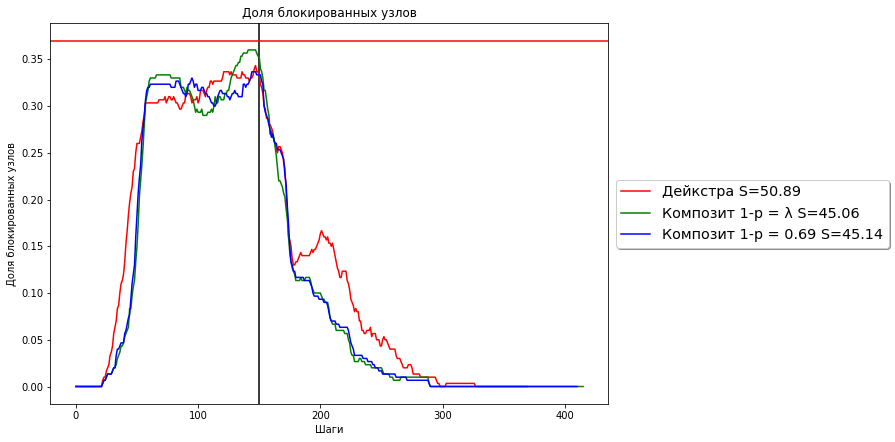

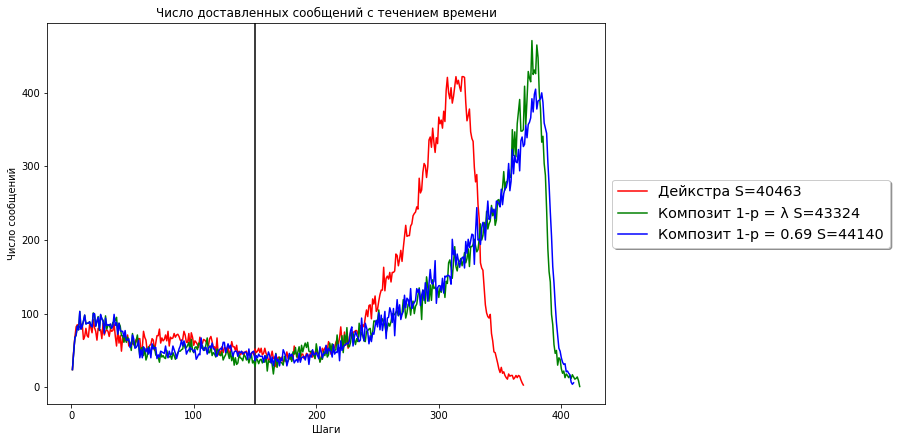

In [7]:
quantity = 300;  
log_tags = [
 {"tag":  "87db3e2e-ab09-48b0-acdf-e69f06000caf", "label": "Дейкстра", "color": "red"},
 {"tag":  "85805901-2bd0-463b-86b8-85ee025bfae7", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "5db7d64a-e901-4270-a073-536a19f4283a", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "b6a6b087-acd6-48b3-982e-2d108df2bccf", "label": "Дейкстра", "color": "red"},
 {"tag":  "69f43a36-a8bf-4fed-8a01-b9443bd5b0e5", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "9b8cf6f4-8c92-44f3-8397-8327ef98cb4a", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "3e16359f-c1da-40b8-974d-a9def249407a", "label": "Дейкстра", "color": "red"},
 {"tag":  "b277904f-1446-4e8c-b905-eb6787af6e6e", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "2ca42013-739e-4b4e-84ce-5b9df4cc74d4", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

quantity = 1300;  
log_tags = [
 {"tag":  "5b656abd-a5ff-4059-aabe-1cca66b18019", "label": "Дейкстра", "color": "red"},
 {"tag":  "9ea6d1df-5ca6-4f01-82fa-775b9978b14a", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "862b51b1-fb3f-41bf-9790-21a16acb27bf", "label": "Композит 1-p = 0.69", "color": "blue"},
]
showStatBlocked();  
showStatMessage();

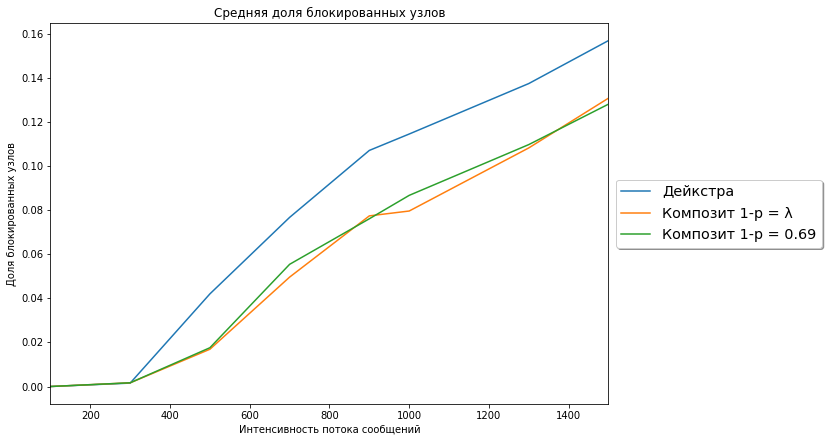

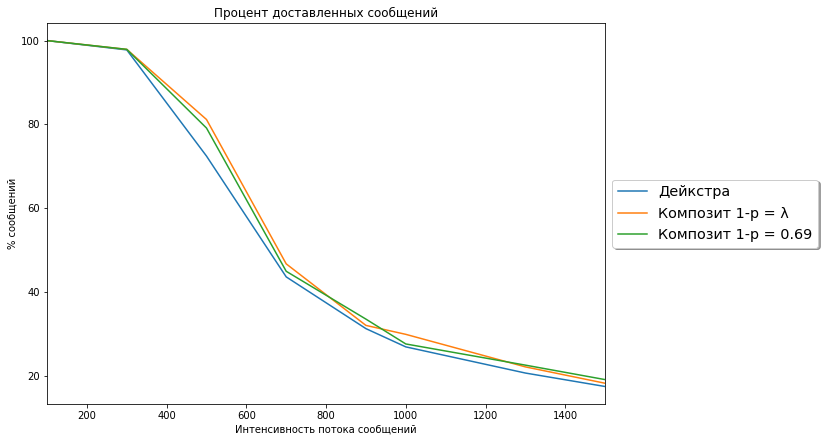

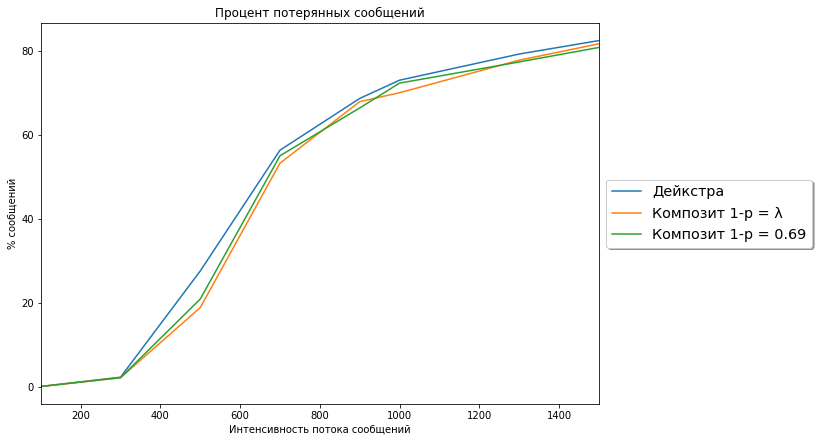

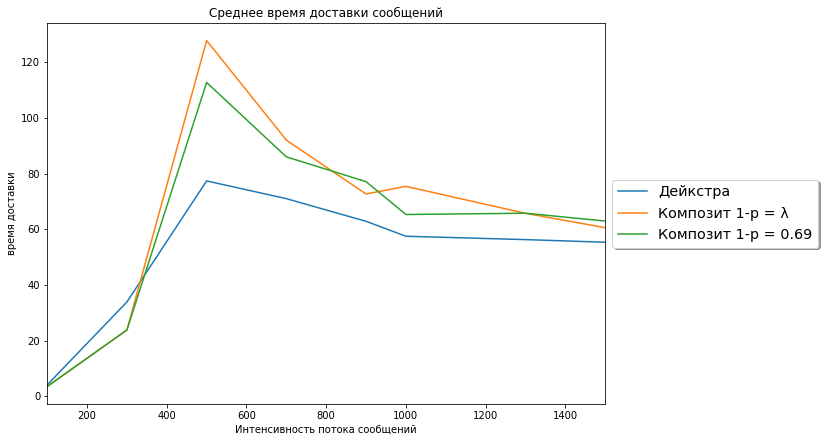

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()




In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())


Дейкстра               0.079599
Композит 1-p = λ       0.058079
Композит 1-p = 0.69    0.059465

Дейкстра               48.685488
Композит 1-p = λ       46.442065
Композит 1-p = 0.69    46.856109

Дейкстра               52.293305
Композит 1-p = λ       65.207447
Композит 1-p = 0.69    62.162304
